# Phishing url Classification

In [0]:
#Copyright 2019, Seokjun Bu, Softcomputing LAB all rights reserved.
%matplotlib inline
import keras
import gc
import random
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from itertools import permutations
from keras import backend as K
from keras.models import Model, load_model, Sequential
from keras.utils import np_utils, multi_gpu_model, plot_model
from keras.callbacks import EarlyStopping
from keras.layers import Input, concatenate, Reshape, Flatten, Dense, Conv2D, MaxPool2D, Dropout, BatchNormalization, Conv1D, MaxPool1D, UpSampling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
from skimage.measure import compare_ssim as ssim

from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import AveragePooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Input, Concatenate
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
import keras.backend as K
from keras.models import Model
from keras.layers import Input, merge, ZeroPadding2D
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import keras.backend as K
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from PIL import Image

Using TensorFlow backend.


In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

# 프로젝트 시스템 아키텍쳐(개념도)

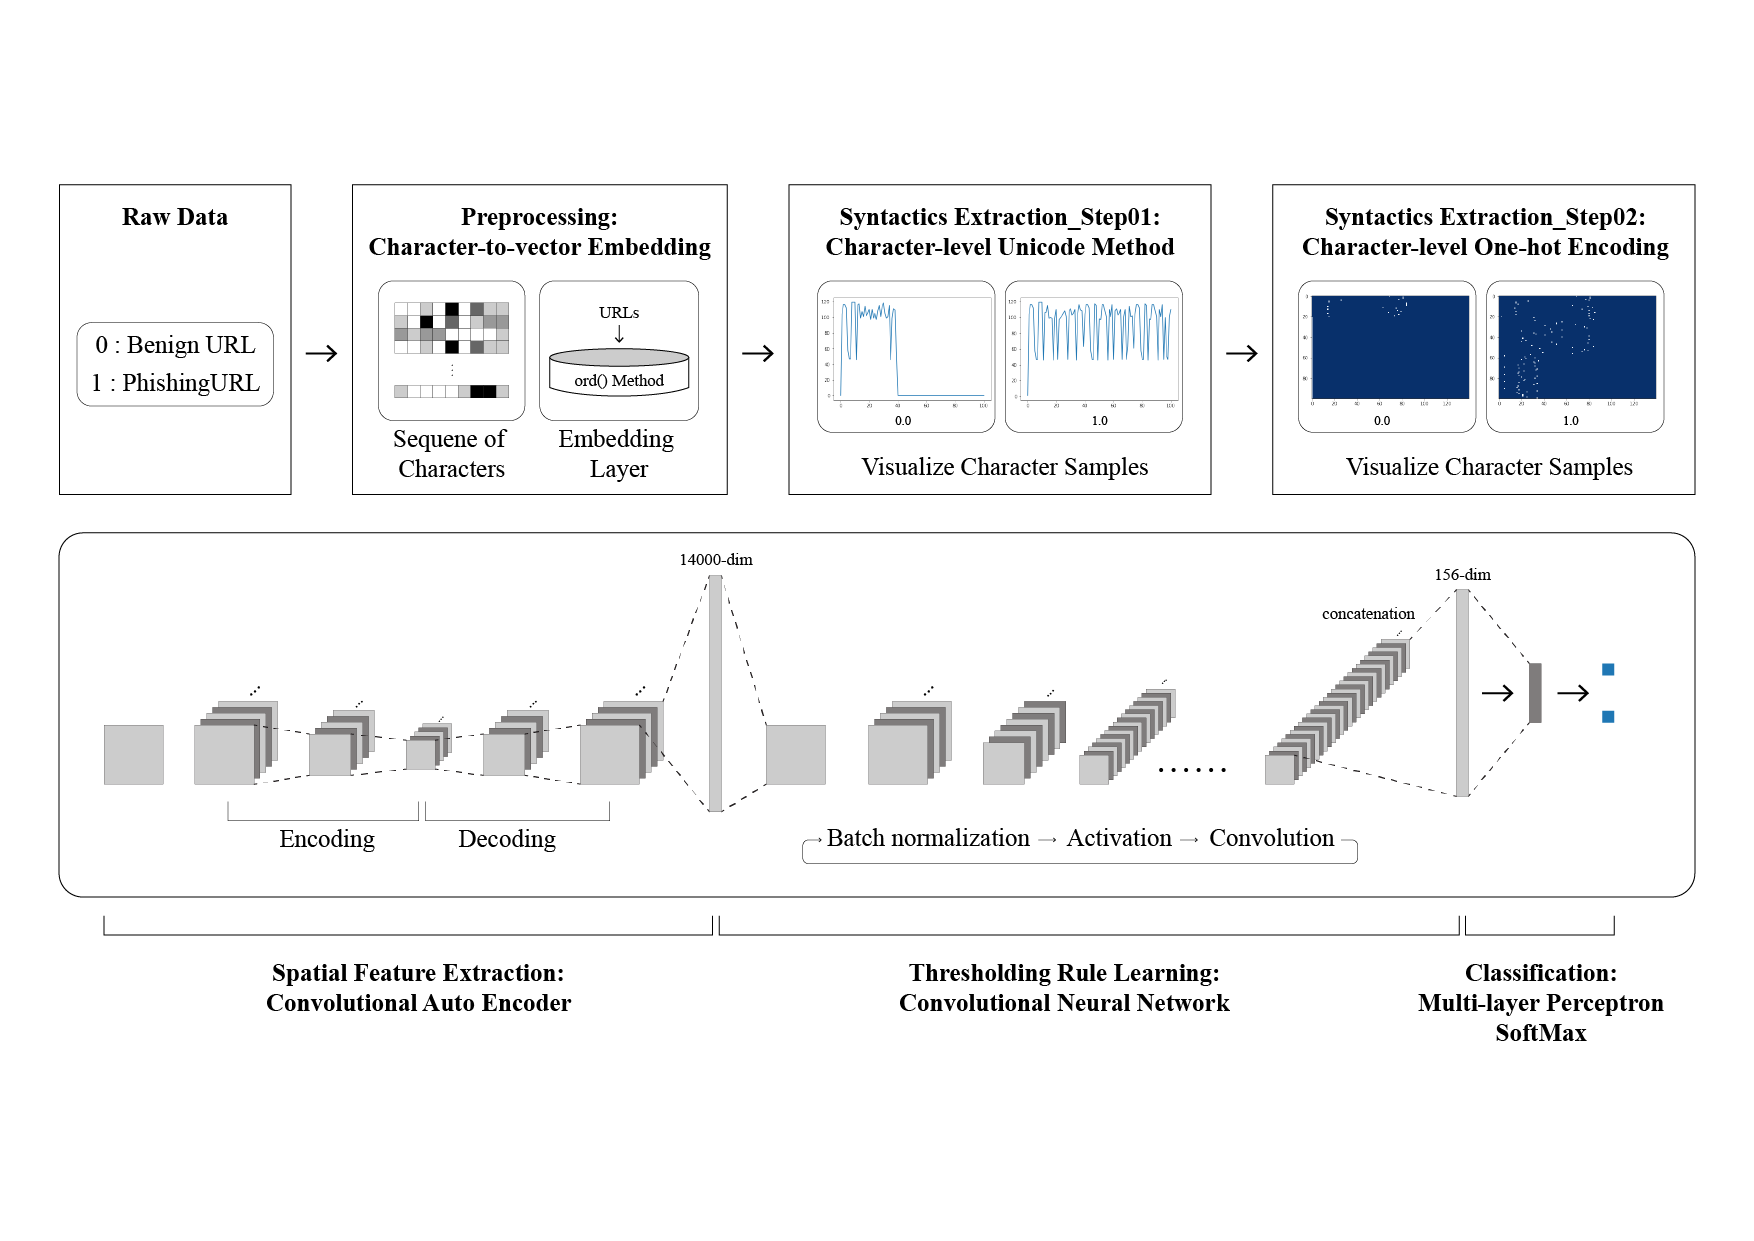

In [0]:
img0 = Image.open("/content/drive/My Drive/test_colab/img.png")
img0

# Feature Engineering

In [0]:
n_neutral, n_phishing = 45000, 15000
n_max_char = 100

dataset_neutral = pd.read_csv('/content/drive/My Drive/test_colab/url_0.csv', header=None, skiprows=0).sample(n=n_neutral, random_state=11)
dataset_neutral = dataset_neutral[1].values

dataset_phishing = pd.read_csv('/content/drive/My Drive/test_colab/url_1.csv', header=None, skiprows=0).sample(n=n_phishing, random_state=11)
dataset_phishing = dataset_phishing[1].values

def length_info(input_str_np):
    min_length, avg_length, max_length = 999, 0, 0
    for r in range(input_str_np.shape[0]):
        length_buffer = len(input_str_np[r])
        if(length_buffer>max_length):
            max_length = length_buffer
        if(length_buffer<min_length):
            min_length = length_buffer
        avg_length += length_buffer
    avg_length /= input_str_np.shape[0]
    return(min_length, avg_length, max_length)
print(length_info(dataset_neutral))
print(length_info(dataset_phishing))

(14, 35.8264, 441)
(12, 75.73886666666667, 4096)


In [0]:
dataset_string = []
for r in range(dataset_neutral.shape[0]):
    row_buffer = []
    row_buffer.append(0)
    row_buffer.append(dataset_neutral[r])
    dataset_string.append(row_buffer)
for r in range(dataset_phishing.shape[0]):
    row_buffer = []
    row_buffer.append(1)
    row_buffer.append(dataset_phishing[r])
    dataset_string.append(row_buffer)

print(dataset_string)
dataset_string = np.asarray(dataset_string)
print(dataset_string, dataset_string.shape)

# np.save('dataset_0_string_45000_15000', dataset_string)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[['0' 'http://www.meigaoyi.com']
 ['0'
  'http://www.cybertruffle.org.uk/vinales/eng/schefflera_morototoni.htm']
 ['0' 'http://prague.tv/funny-pictures-archive/']
 ...
 ['1'
  'http://www.auto-ecole-rennes.com/wp-includes/Text/Diff/83b3926efe21b0905f3eddd62a07bbeb/1/']
 ['1'
  'http://coolestspotontheweb.com/wp-content/plugins/ubh/agrement/a78b30fdd6908e5aa971670752a62dfa/customer_center/customer-IDPP00C572/myaccount/signin/']
 ['1'
  'http://www.niagamall.com/wp-includes/widgets/bankingofamerica.com/update.html']] (60000, 2)


In [0]:
dataset_np = np.zeros((n_neutral+n_phishing, n_max_char+1))
for r in range(dataset_neutral.shape[0]):
    dataset_np[r, 0] = 0
    length_buffer = len(dataset_neutral[r])
    for c in range(n_max_char):
        if(c<length_buffer):
            dataset_np[r, c+1] = ord(dataset_neutral[r][c])
        else:
            break
for r in range(dataset_phishing.shape[0]):
    dataset_np[r+dataset_neutral.shape[0], 0] = 1
    length_buffer = len(dataset_phishing[r])
    for c in range(n_max_char):
        if(c<length_buffer):
            dataset_np[r+dataset_neutral.shape[0], c+1] = ord(dataset_phishing[r][c])
        else:
            break
print(dataset_np)

[[  0. 104. 116. ...   0.   0.   0.]
 [  0. 104. 116. ...   0.   0.   0.]
 [  0. 104. 116. ...   0.   0.   0.]
 ...
 [  1. 104. 116. ...   0.   0.   0.]
 [  1. 104. 116. ... 117. 115. 116.]
 [  1. 104. 116. ...   0.   0.   0.]]


0.0


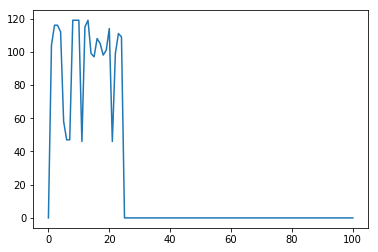

1.0


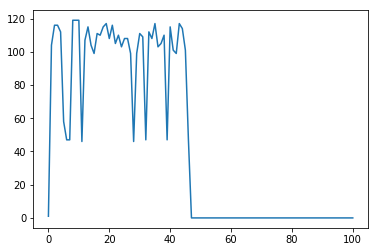

0.0


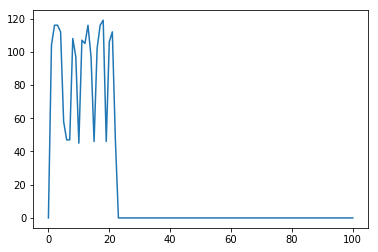

In [0]:
# Visualize char samples
n_v_sample = 3
rand_idx = np.random.randint(0, dataset_np.shape[0], n_v_sample)
for r in range(rand_idx.shape[0]):
    print(dataset_np[rand_idx[r], 0])
    plt.plot(dataset_np[rand_idx[r]])
    plt.show()

In [0]:
# Integer (60000, 100) -> One-hot (60000, 100, xx)
dataset_char_X = dataset_np[:, 1:]
unique_char_list = np.unique(dataset_char_X).astype(int)
unique_char_list = np.append(unique_char_list, [1])
n_char = unique_char_list.shape[0] #140 char available
print(unique_char_list, n_char)
dataset_char_cat_X = np.zeros((dataset_neutral.shape[0]+dataset_phishing.shape[0], dataset_char_X.shape[1], n_char))
for r in range(60000):
    for c in range(dataset_char_cat_X.shape[1]):
        dataset_char_cat_X[r, c, [np.argwhere(unique_char_list==dataset_char_X[r, c])[0][0]]] = 1
    if(r%1000==0):
        print(r)
# Concatenate with Y, Flatten
dataset_char_cat_flatten = np.zeros((dataset_neutral.shape[0]+dataset_phishing.shape[0], 1+dataset_char_X.shape[1]*n_char))
for r in range(dataset_neutral.shape[0]+dataset_phishing.shape[0]):
    dataset_char_cat_flatten[r, 0] = dataset_np[r, 0]
    dataset_char_cat_flatten[r, 1:] = dataset_char_cat_X[r].flatten()

140
1.0


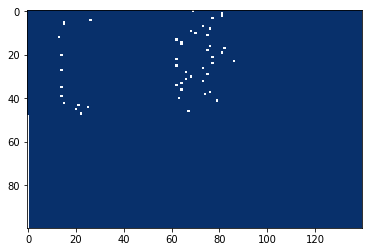

0.0


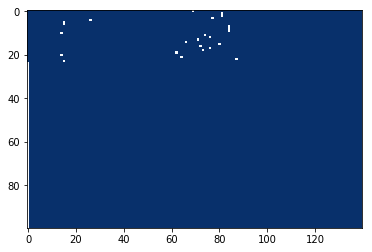

0.0


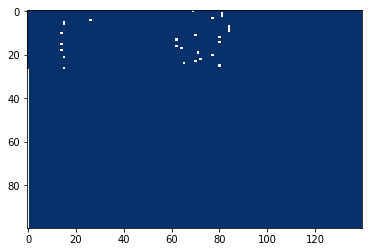

In [0]:
print(n_char)# Visualize char-cat samples
n_v_sample = 3
rand_idx = np.random.randint(0, dataset_neutral.shape[0]+dataset_phishing.shape[0], n_v_sample)
for r in range(rand_idx.shape[0]):
    print(dataset_char_cat_flatten[rand_idx[r], 0])
    plt.imshow(dataset_char_cat_X[rand_idx[r]], aspect='auto', cmap='Blues_r')
    plt.show()

# Recall by Model
 - Logistic Regression
 - Multinomial Naive Bayes
 - Decision tree
 - Random Forest
 - Gradient Boosting
 - XGBooster
 - SVC 
 - MLP
 - CNN

In [0]:
df = pd.read_csv('/content/drive/My Drive/test_colab/model_recall_score.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

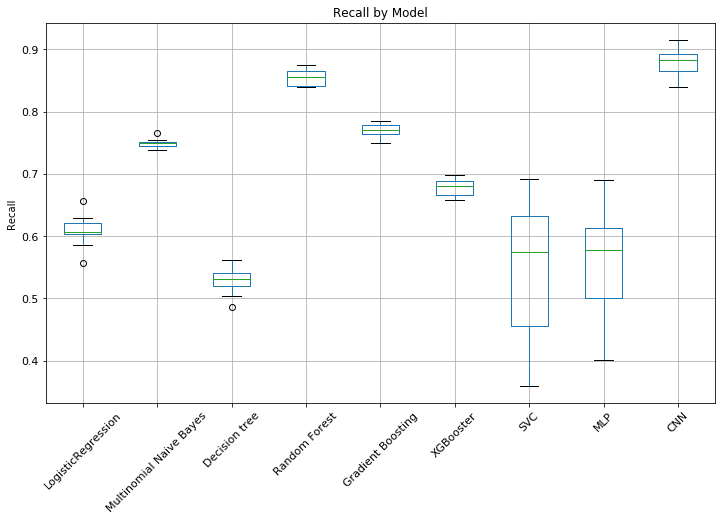

In [0]:
## boxplot
plt.figure(figsize=(12, 7))
df.boxplot(column= ['LogisticRegression', 'Multinomial Naive Bayes', 'Decision tree', 'Random Forest', 'Gradient Boosting', 'XGBooster', 'SVC', 'MLP', 'CNN']) 
plt.xticks(size = 11, rotation=45)
plt.yticks(size = 11)
plt.title('Recall by Model')
plt.ylabel("Recall")
plt.show()

In [0]:
# Load Dataset
dataset = np.load('/content/gdrive/My Drive/DL/dataset_2_char_cat_45000_15000_140.npy')
print(dataset.shape)

(60000, 14001)


In [0]:
# Train, Test Split
# Train: for CAE Learning + Detection Thresholding
# Test: only for Validation
X, Y = dataset[:, 1:], dataset[:, 0]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, shuffle=True, random_state=11)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(42000, 14000) (42000,)
(18000, 14000) (18000,)


In [0]:
Y_train_cat, Y_test_cat = np_utils.to_categorical(Y_train), np_utils.to_categorical(Y_test)

In [0]:
#Call Models
cnn_model = load_model('/content/gdrive/My Drive/DL/cnn.h5')
cae_model = load_model('/content/gdrive/My Drive/DL/cae.h5')
classifier_model = load_model('/content/gdrive/My Drive/DL/classifier.h5')
densenet = load_model('/content/gdrive/My Drive/DL/densenet.h5')

In [0]:
# Lock Weight
for i, l in enumerate(cae_model.layers):
    l.trainable = False
    l.name = 'cae_'+str(i)
cae_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cae_0 (InputLayer)           (None, 14000)             0         
_________________________________________________________________
cae_1 (Reshape)              (None, 100, 140, 1)       0         
_________________________________________________________________
cae_2 (Conv2D)               (None, 100, 140, 32)      160       
_________________________________________________________________
cae_3 (MaxPooling2D)         (None, 50, 70, 32)        0         
_________________________________________________________________
cae_4 (Conv2D)               (None, 50, 70, 32)        4128      
_________________________________________________________________
cae_5 (MaxPooling2D)         (None, 25, 35, 32)        0         
_________________________________________________________________
cae_6 (Conv2D)               (None, 25, 35, 32)        4128

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [0]:
def conv_block(x, stage, branch, nb_filter, dropout_rate=None, weight_decay=1e-4):
    
    # BN --> ReLu --> Bottleneck (1X1) Conv --> (3X3) Conv --> Dropout : 얘네를 모아서(Concat해서) dense block 을 만든다

    eps = 1.1e-5
    conv_name_base = 'conv' + str(stage) + '_' + str(branch)
    relu_name_base = 'relu' + str(stage) + '_' + str(branch)

    # 1x1 Convolution (Bottleneck layer)
    inter_channel = nb_filter * 4  
    x = BatchNormalization(epsilon=eps, axis=3, name=conv_name_base+'_x1_bn')(x)
    x = Activation('relu', name=relu_name_base+'_x1')(x)
    x = Convolution2D(inter_channel, 1, 1, name=conv_name_base+'_x1', bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    # 3x3 Convolution
    x = BatchNormalization(epsilon=eps, axis=3, name=conv_name_base+'_x2_bn')(x)
    x = Activation('relu', name=relu_name_base+'_x2')(x)
    x = ZeroPadding2D((1, 1), name=conv_name_base+'_x2_zeropadding')(x)
    x = Convolution2D(nb_filter, 3, 3, name=conv_name_base+'_x2', bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    return x

In [0]:
def dense_block(x, stage, nb_layers, nb_filter, growth_rate, 
                dropout_rate=None, weight_decay=1e-4, grow_nb_filters=True):
    
    #Conv Block 들을 Concat 해주는 역할
   
    #grow_nb_filters: flag to decide to allow number of filters to grow

    eps = 1.1e-5
    
    # concat 할 대상
    concat_feat = x
    
    #for loop 을 layer 개수만큼 돌면서 concat
    #filter 를 growth rate 만큼 늘려가면서 concat 한다
    #Stage 와 branch 는 그냥 index
    
    for i in range(nb_layers):
        branch = i+1
        x = conv_block(concat_feat, stage, branch, growth_rate, dropout_rate, weight_decay)
        concat_feat = keras.layers.concatenate([concat_feat, x], name='concat_'+str(stage)+'_'+str(branch))

        if grow_nb_filters:
            nb_filter += growth_rate

    return concat_feat, nb_filter

In [0]:
def transition_block(x, stage, nb_filter, compression=1.0, dropout_rate=None, weight_decay=1E-4):
    
    #BN 에 필요한 constant 
    eps = 1.1e-5
    
    #이름붙이기
    conv_name_base = 'conv' + str(stage) + '_blk'
    relu_name_base = 'relu' + str(stage) + '_blk'
    pool_name_base = 'pool' + str(stage) 
    
    #Transition Block 의 Sequence : BN --> ReLu --> Conv(1,1)
    x = BatchNormalization(epsilon=eps, axis=3, name=conv_name_base+'_bn')(x)
    x = Activation('relu', name=relu_name_base)(x)
    x = Convolution2D(int(nb_filter * compression), 1, 1, name=conv_name_base, bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    x = AveragePooling2D((2, 2), strides=(2, 2), name=pool_name_base)(x)

    return x

In [0]:
cae_model.get_layer('cae_12').output

<tf.Tensor 'flatten_4/Reshape:0' shape=(?, ?) dtype=float32>

In [0]:
def DenseNet(nb_dense_block=4, growth_rate=48, nb_filter=96, reduction=0.0, 
             dropout_rate=0.0, weight_decay=1e-4, classes=2):

         
    eps = 1.1e-5

    # Transition Block 을 통과하며 줄어드는 차원 비율
    compression = 1.0 - reduction
    
    # 논문 기준 filter 수
    nb_filter = 96
    nb_layers = [6,12,36,24] # For DenseNet-161

    # Initial Convolution
    # Reshape --> ZeroPadding --> Conv --> BN --> ReLu --> ZeroPadding --> MaxPooling
    cae_output = cae_model.get_layer('cae_12').output
    x = Reshape((100, 140, 1))(cae_output)
    x = ZeroPadding2D((3, 3), name='conv1_zeropadding')(x)
    x = Convolution2D(nb_filter, 7, 7, subsample=(2, 2), name='conv1', bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=3, name='conv1_bn')(x)
    x = Activation('relu', name='relu1')(x)
    x = ZeroPadding2D((1, 1), name='pool1_zeropadding')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='pool1')(x)

    # Dense Block 추가
    # Dense Block = Conv_Block 을 Concat 한 것
    # (Bottleneck layer) BN -> ReLu --> Conv(1,1) --> Dropout  --> (3x3 Convolution) BN --> ReLu --> Zeropadding(1,1) --> Conv2D(3,3) --> Dropout

    for block_idx in range(nb_dense_block - 1):
        stage = block_idx+2
        x, nb_filter = dense_block(x, stage, nb_layers[block_idx], nb_filter, 
                                   growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)

        # Transition Block 추가
        x = transition_block(x, stage, nb_filter, compression=compression, 
                             dropout_rate=dropout_rate, weight_decay=weight_decay)
        nb_filter = int(nb_filter * compression)

    final_stage = stage + 1
    x, nb_filter = dense_block(x, final_stage, nb_layers[-1], nb_filter, 
                               growth_rate, dropout_rate=dropout_rate, 
                               weight_decay=weight_decay)

    x = BatchNormalization(epsilon=eps, axis=3, name='conv'+str(final_stage)+'_blk_bn')(x)
    x = Activation('relu', name='relu'+str(final_stage)+'_blk')(x)
    
    #GAP는 파라미터 수를 줄여 오버피팅을 방지하는 기능
    x = GlobalAveragePooling2D(name='pool'+str(final_stage))(x)

    x = Dense(classes, name='fc6')(x)
    x = Activation('softmax', name='prob')(x)

    model = Model(cae_model.input, x, name='densenet')

    return model

In [0]:
densenet = DenseNet(nb_dense_block=2, growth_rate=4, nb_filter=8, reduction=0.5, dropout_rate=0.5, weight_decay=1e-4, classes=2)

In [0]:
from keras import optimizers
adam = Adam(lr = 1e-04)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
densenet.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='auto', patience=10,restore_best_weights = True)

In [0]:
%%time
history_densenet = densenet.fit(X_train, Y_train_cat, validation_data=(X_test, Y_test_cat), 
                                                epochs=200, batch_size=32, verbose=2, callbacks = [es])

Train on 42000 samples, validate on 18000 samples
Epoch 1/200
 - 257s - loss: 0.3594 - acc: 0.8527 - val_loss: 0.2672 - val_acc: 0.9011
Epoch 2/200
 - 236s - loss: 0.2417 - acc: 0.9034 - val_loss: 0.2295 - val_acc: 0.9242
Epoch 3/200
 - 233s - loss: 0.2197 - acc: 0.9127 - val_loss: 0.2115 - val_acc: 0.9247
Epoch 4/200
 - 234s - loss: 0.2078 - acc: 0.9177 - val_loss: 0.1935 - val_acc: 0.9328
Epoch 5/200
 - 235s - loss: 0.1987 - acc: 0.9220 - val_loss: 0.2500 - val_acc: 0.9018
Epoch 6/200
 - 235s - loss: 0.1955 - acc: 0.9233 - val_loss: 0.1988 - val_acc: 0.9220
Epoch 7/200
 - 235s - loss: 0.1865 - acc: 0.9268 - val_loss: 0.2614 - val_acc: 0.8967
Epoch 8/200
 - 235s - loss: 0.1838 - acc: 0.9289 - val_loss: 0.3749 - val_acc: 0.8506
Epoch 9/200
 - 235s - loss: 0.1798 - acc: 0.9297 - val_loss: 0.1710 - val_acc: 0.9333
Epoch 10/200
 - 235s - loss: 0.1767 - acc: 0.9305 - val_loss: 0.1984 - val_acc: 0.9199
Epoch 11/200
 - 235s - loss: 0.1736 - acc: 0.9331 - val_loss: 0.1677 - val_acc: 0.9326
Ep

In [0]:
# densenet.save('/content/gdrive/My Drive/DL/densenet.h5')

In [0]:
Y_test_hat_ours = densenet.predict(X_test)
Y_test_hat_cnn = cnn_model.predict(X_test)

In [0]:
print(confusion_matrix(Y_test, np.argmax(Y_test_hat_ours, axis=1)))
print(confusion_matrix(Y_test, np.argmax(Y_test_hat_cnn, axis=1)))
print(classification_report(Y_test, np.argmax(Y_test_hat_ours, axis=1)))
print(classification_report(Y_test, np.argmax(Y_test_hat_cnn, axis=1)))

[[13173   373]
 [  544  3910]]
[[13226   320]
 [  662  3792]]
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     13546
         1.0       0.91      0.88      0.90      4454

    accuracy                           0.95     18000
   macro avg       0.94      0.93      0.93     18000
weighted avg       0.95      0.95      0.95     18000

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96     13546
         1.0       0.92      0.85      0.89      4454

    accuracy                           0.95     18000
   macro avg       0.94      0.91      0.92     18000
weighted avg       0.94      0.95      0.94     18000



In [0]:
#Experiment Session

In [0]:
import random

def imbalance_gen(ratio):
  #X_test, Y_test 합치기
  stacked = np.hstack((Y_test.reshape(18000,1),X_test))

  #정상, 비정상 분류
  benigns = stacked[stacked[:, 0] == 0]
  phishs = stacked[stacked[:, 0] == 1]

  #생성된 데이터가 들어갈 자리 만들기
  X_gen = np.zeros((int(np.sum(Y_test)), X_test.shape[1]))
  Y_gen = np.zeros((int(np.sum(Y_test)),))


  #정상개수, 비정상개수
  num_benign = int(round(np.sum(Y_test) * (1 - ratio)))
  num_phish = int(np.sum(Y_test)) - num_benign

  #정상, 비정상 인덱스 리스트
  random_idxs_benign = np.arange(0, benigns.shape[0], 1).tolist()
  random_idxs_phish = np.arange(0, phishs.shape[0] ,1).tolist()

  #정상고르기
  for i in range(num_benign):
    random_idx_benign = random.choice(random_idxs_benign)
    X_gen[i,:] = benigns[random_idx_benign, 1:]
    Y_gen[i] = benigns[random_idx_benign, 0]

  #비정상고르기
  for i in range(num_benign, num_benign + num_phish, 1):
    random_idx_phish = random.choice(random_idxs_phish)
    X_gen[i,:] = phishs[random_idx_phish, 1:]
    Y_gen[i] = phishs[random_idx_phish, 0]
  return X_gen, Y_gen

In [0]:
#실험 1.Noise robustness test

def noise_robustness(model1,model2,factor,strength):
  
  #Our Results
  recalls_ours = []
  precisions_ours = []
  accuracies_ours = []
  fallouts_ours = []
  
  #CNN Results
  recalls_cnn = []
  precisions_cnn = []
  accuracies_cnn = []
  fallouts_cnn = []
  
  for str in strength:
    noise = factor * np.random.normal(loc = 0, scale = 1 + str, size=(X_test.shape[0], X_test.shape[1]))
    
    y_hat_ours = model1.predict(X_test + noise)
    y_hat_cnn = model2.predict(X_test + noise)
    
    conf_mat_ours = confusion_matrix(Y_test, np.argmax(y_hat_ours, axis = 1))
    conf_mat_cnn = confusion_matrix(Y_test, np.argmax(y_hat_cnn, axis = 1))
    
    recall_ours = conf_mat_ours[1,1]/ np.sum(conf_mat_ours[1,:])
    precision_ours = conf_mat_ours[0,0]/ np.sum(conf_mat_ours[0,:])
    accuracy_ours = (conf_mat_ours[0,0] + conf_mat_ours[1,1])/ np.sum(conf_mat_ours)
    fallout_ours = (conf_mat_ours[0,1]) / np.sum(conf_mat_ours[0,:])
                                            
    recalls_ours.append(recall_ours)
    precisions_ours.append(precision_ours)
    accuracies_ours.append(accuracy_ours)
    fallouts_ours.append(fallout_ours)
                                            
    recall_cnn = conf_mat_cnn[1,1]/ np.sum(conf_mat_cnn[1,:])
    precision_cnn = conf_mat_cnn[0,0]/ np.sum(conf_mat_cnn[0,:])
    accuracy_cnn = (conf_mat_cnn[0,0] + conf_mat_cnn[1,1])/ np.sum(conf_mat_cnn)
    fallout_cnn = (conf_mat_cnn[0,1]) / np.sum(conf_mat_cnn[0,:])
                                           
    recalls_cnn.append(recall_cnn)
    precisions_cnn.append(precision_cnn)
    accuracies_cnn.append(accuracy_cnn)
    fallouts_cnn.append(fallout_cnn)
    
  return recalls_ours ,precisions_ours,accuracies_ours,fallouts_ours, recalls_cnn, precisions_cnn, accuracies_cnn, fallouts_cnn

In [0]:
%%time
recalls_ours ,precisions_ours,accuracies_ours,fallouts_ours, recalls_cnn, precisions_cnn, accuracies_cnn, fallouts_cnn = noise_robustness(densenet, cnn_model, 0.01, [0,0.05,0.1,0.15,0.2])


CPU times: user 2min 39s, sys: 44.6 s, total: 3min 23s
Wall time: 4min 11s


$Noise\ = factor(0.01)\ *\  N(\mu\ =\ 0, \ \sigma^2+strength)$

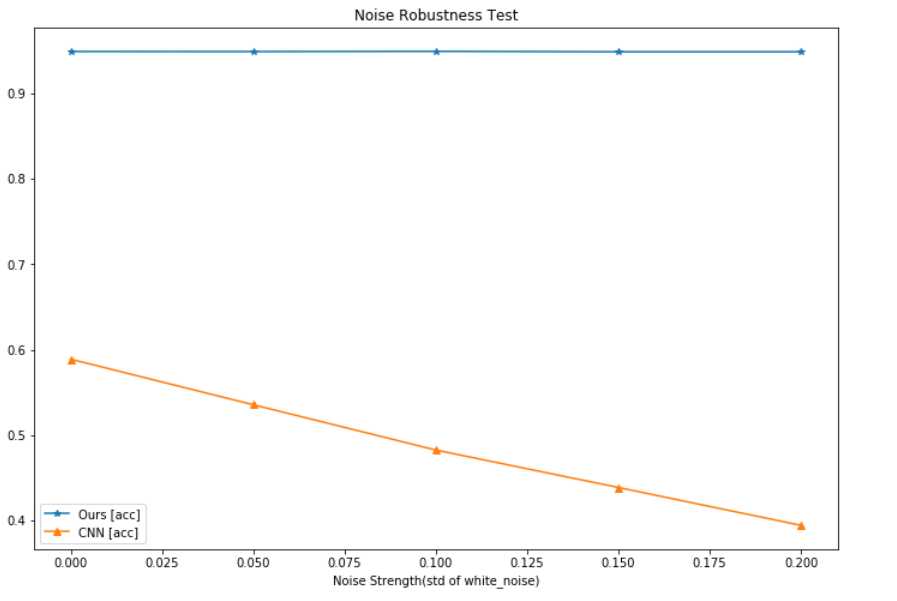

In [0]:
plt.plot(recalls_ours, label = 'Ours [recall]', marker = 'o')
plt.plot(recalls_cnn, label = 'CNN [recall]', marker = 's')
# plt.plot(accuracies_ours, label = 'Ours [acc]', marker = '*')
# plt.plot(accuracies_cnn, label = 'CNN [acc]', marker = '^')
# plt.xlabel('Noise Strength(std of white_noise)')
# plt.legend()
img = Image.open("/content/drive/My Drive/test_colab/Noise.png")
img

In [0]:
# 실험 2. Zero day attack robustness test

def imbalance_robustness(model1, model2, ratios):
  #Our Results
  recalls_ours = []
  precisions_ours = []
  accuracies_ours = []
  fallouts_ours = []
  
  #CNN Results
  recalls_cnn = []
  precisions_cnn = []
  accuracies_cnn = []
  fallouts_cnn = []
  
  for ratio in ratios:
    X_gen, Y_gen = imbalance_gen(ratio = ratio)
    
    y_hat_ours = model1.predict(X_gen)
    y_hat_cnn = model2.predict(X_gen)
    
    conf_mat_ours = confusion_matrix(Y_gen, np.argmax(y_hat_ours, axis = 1))
    conf_mat_cnn = confusion_matrix(Y_gen, np.argmax(y_hat_cnn, axis = 1))
    
    recall_ours = conf_mat_ours[1,1]/ np.sum(conf_mat_ours[1,:])
    precision_ours = conf_mat_ours[0,0]/ np.sum(conf_mat_ours[0,:])
    accuracy_ours = (conf_mat_ours[0,0] + conf_mat_ours[1,1])/ np.sum(conf_mat_ours)
    fallout_ours = (conf_mat_ours[0,1]) / np.sum(conf_mat_ours[0,:])
                                            
    recalls_ours.append(recall_ours)
    precisions_ours.append(precision_ours)
    accuracies_ours.append(accuracy_ours)
    fallouts_ours.append(fallout_ours)
                                            
    recall_cnn = conf_mat_cnn[1,1]/ np.sum(conf_mat_cnn[1,:])
    precision_cnn = conf_mat_cnn[0,0]/ np.sum(conf_mat_cnn[0,:])
    accuracy_cnn = (conf_mat_cnn[0,0] + conf_mat_cnn[1,1])/ np.sum(conf_mat_cnn)
    fallout_cnn = (conf_mat_cnn[0,1]) / np.sum(conf_mat_cnn[0,:])
                                           
    recalls_cnn.append(recall_cnn)
    precisions_cnn.append(precision_cnn)
    accuracies_cnn.append(accuracy_cnn)
    fallouts_cnn.append(fallout_cnn)
    
  return recalls_ours ,precisions_ours,accuracies_ours,fallouts_ours, recalls_cnn, precisions_cnn, accuracies_cnn, fallouts_cnn

In [0]:
%%time
recalls_ours ,precisions_ours,accuracies_ours, fallouts_ours, recalls_cnn, precisions_cnn, accuracies_cnn, fallouts_cnn = imbalance_robustness(densenet, cnn_model, [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

CPU times: user 57.9 s, sys: 16.5 s, total: 1min 14s
Wall time: 1min 37s


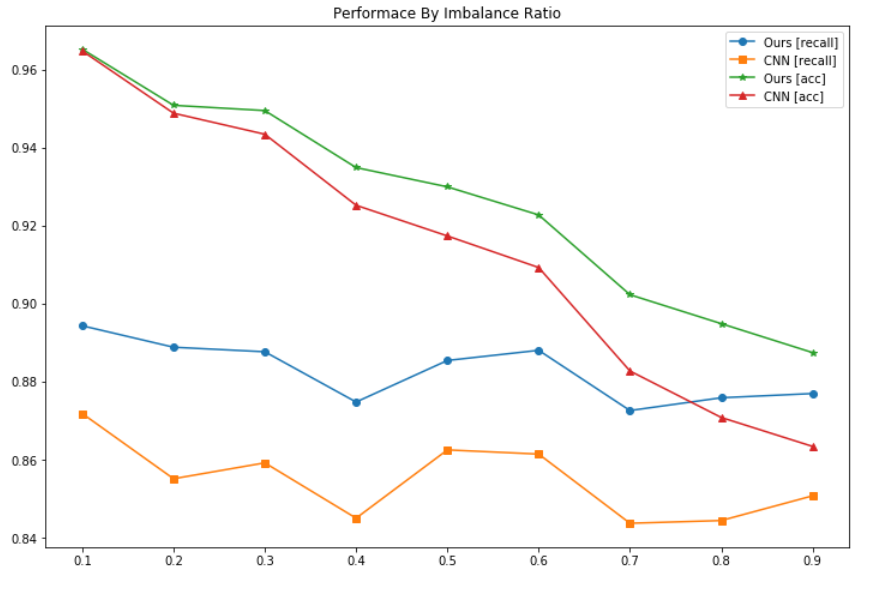

In [0]:
# plt.plot([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],recalls_ours, label = 'Ours [acc]', marker = 'o')
# plt.plot([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],recalls_cnn, label = 'CNN [recall]', marker = 's')
# plt.plot([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],accuracies_ours, label = 'Ours [acc]', marker = '*')
# plt.plot([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],accuracies_cnn, label = 'CNN [acc]', marker = '^')
# plt.legend()
img2 = Image.open("/content/drive/My Drive/test_colab/two.png")
img2

#References
- Gao Huang, Zhuang Liu, Laurens van der Maaten, Kilian Q. Weinberger(2016). : *Densely Connected Convolutional Networks.*
- Jonathan Masci, Ueli Meier, Dan Cire¸san, and J¨urgen Schmidhuber(2011). : *Stacked Convolutional Auto-Encoders for Hierarchical Feature Extraction*
- Jaime Zabalza, Jinchang Ren, Jiangbin Zheng, Huimin Zhao, Chunmei Qing, Zhijing Yang,Stephen Marshall(2015). : *Novel Segmented Stacked AutoEncoder for Effective Dimensionality Reduction and Feature Extraction in Hyperspectral Imaging*